## Modules and data preparation

In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import *
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
def figure_setup(fig_size: tuple=(16,9), dpi: int=90):
    sns.set()
    return plt.figure(figsize=fig_size, dpi=dpi)

fig = figure_setup()

<Figure size 1440x810 with 0 Axes>

In [3]:
from pandas import DataFrame

def data_normalization(df: DataFrame, days_range: int=24, include_cur_row: bool=True):
    '''
    Return the normalized data:
    + df: the dataframe to be normalized
    + range: the number of previous rows (or including the current row) to be considered in the normalization
    + include_cur_row: True if we consider the current row in the normalization process (calculate mean and std
    using the current row and (range-1) previous rows), False if we want to use all the passed data for normalization 
    processing ((calculate mean and std using (range) previous rows))
    '''
    
    df_roll = None

    if include_cur_row == False:
        df_roll = df.rolling(days_range, closed='left')
    else:
        df_roll = df.rolling(days_range)
        days_range -= 1
        
    res_df = (df - df_roll.mean()) / df_roll.std()
    res_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return res_df[days_range:]

In [4]:
original_df = pd.read_csv("features_joined_with_trend_seasonal_and_volume.csv")
df = pd.read_csv("features_joined_with_trend_seasonal_and_volume.csv")
periods = [2,4,8,12,24,48,96,192]

## Data preprocessing

In [5]:
df.drop(columns=["Unnamed: 0", "time_open"], inplace=True)

In [6]:
for c in df.columns:
    print(c)

open
high
low
close
volume
quote_asset_volume
number_of_trades
taker_buy_base_asset_volume
taker_buy_quote_asset_volume
exchange_reserve
exchange_reserve_USD
exchange_inflow
exchange_outflow
exchange_in_house_flow
exchange_whale_ratio
exchange_supply_ratio
miner_reserve
miner_reserve_USD
miner_outflow
miner_inflow
coinbase_premium_index
CoppockCurve
KAMA
KST_kst
KST_signal
MACD_macd
MACD_signal
MassIndex
OBV
KVO
VWAP
AccuDist
BOP
UO
TSI
AO
CCI2
CHOP2
VTX2_plus_vtx
VTX2_minus_vtx
SOBV2
ATR2
ForceIndex2
ADX_plus_di
ADX_minus_di
ADX_adx
open_max2
open_min2
open_median2
open_SMA2
open_SMMA2
open_WMA2
open_ALMA2
open_TEMA2
open_EMA2
open_DEMA2
open_DPO2
open_HMA2
open_MeanDev2
open_StdDev2
open_RSI2
open_ROC2
open_TRIX2
close_max2
close_min2
close_median2
close_SMA2
close_SMMA2
close_WMA2
close_ALMA2
close_TEMA2
close_EMA2
close_DEMA2
close_DPO2
close_HMA2
close_MeanDev2
close_StdDev2
close_RSI2
close_ROC2
close_TRIX2
high_max2
high_min2
high_median2
high_SMA2
high_SMMA2
high_WMA2
high_ALMA

In [7]:
long_period = 360
medium_period = 92
short_period = 24

### MA normalization

In [8]:
MAs = ["SMA", "WMA", "EMA", "HMA", "TEMA", "ALMA", "DEMA", "SMMA"]
price_types = ["open", "high", "low", "close"]

In [9]:
for price_type in price_types:
    for period in periods:
        for ma in MAs:
            col_name1 = price_type + "_" + ma + str(period)
            col_name2 = "cur_" + price_type + "_vs_" + col_name1
            
#             df[col_name2] = (df[price_type] - df[col_name1])/df[col_name1]
#             df[col_name1] = data_normalization(df[col_name1])

            # New
            df[col_name1] = np.log(df[price_type]/df[col_name1])
            print(col_name1)

open_SMA2
open_WMA2
open_EMA2
open_HMA2
open_TEMA2
open_ALMA2
open_DEMA2
open_SMMA2
open_SMA4
open_WMA4
open_EMA4
open_HMA4
open_TEMA4
open_ALMA4
open_DEMA4
open_SMMA4
open_SMA8
open_WMA8
open_EMA8
open_HMA8
open_TEMA8
open_ALMA8
open_DEMA8
open_SMMA8
open_SMA12
open_WMA12
open_EMA12
open_HMA12
open_TEMA12
open_ALMA12
open_DEMA12
open_SMMA12
open_SMA24
open_WMA24
open_EMA24
open_HMA24
open_TEMA24
open_ALMA24
open_DEMA24
open_SMMA24
open_SMA48
open_WMA48
open_EMA48
open_HMA48
open_TEMA48
open_ALMA48
open_DEMA48
open_SMMA48
open_SMA96
open_WMA96
open_EMA96
open_HMA96
open_TEMA96
open_ALMA96
open_DEMA96
open_SMMA96
open_SMA192
open_WMA192
open_EMA192
open_HMA192
open_TEMA192
open_ALMA192
open_DEMA192
open_SMMA192
high_SMA2
high_WMA2
high_EMA2
high_HMA2
high_TEMA2
high_ALMA2
high_DEMA2
high_SMMA2
high_SMA4
high_WMA4
high_EMA4
high_HMA4
high_TEMA4
high_ALMA4
high_DEMA4
high_SMMA4
high_SMA8
high_WMA8
high_EMA8
high_HMA8
high_TEMA8
high_ALMA8
high_DEMA8
high_SMMA8
high_SMA12
high_WMA12
high_E

### Volume MA creation and normalization

In [10]:
# volume_indicators = ["volume", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]

#### Volume MA creation

In [11]:
# for volume_indicator in volume_indicators:
#     for period in periods:
#         df[volume_indicator+"_MA"+str(period)] = df[volume_indicator].rolling(period, closed='left').mean()

#### Volume indicators normalization

In [12]:
volume_indicators = ["quote_asset_volume", "taker_buy_quote_asset_volume"]

In [13]:
for volume_indicator in volume_indicators:
#     df[volume_indicator] = np.log(df[volume_indicator]/(df[volume_indicator].shift(1))) 
#     df[volume_indicator].replace([-np.inf,np.inf], 0, inplace=True)
#     for period in periods:
#         col_name1 = volume_indicator + "_MA" + str(period)
#         df[col_name1] = np.log(df[col_name1]/df[col_name1].shift(1))

    # New
    df[volume_indicator] = data_normalization(df["quote_asset_volume"], days_range=long_period)

In [14]:
# volume_dict_factor = {
#     4: 2,
#     8: 5,
#     12: 5,
#     16: 5,
#     20: 10,
#     24: 10,
#     36: 10,
#     48: 10,
#     72: 20,
#     96: 40
# }

In [15]:
# for volume_indicator in volume_indicators:
#     for period in periods:
#         df[volume_indicator+"_MA"+str(period)] *= volume_dict_factor[period]

In [16]:
df.drop(columns=["volume_ts_y"], inplace=True)
df.rename(columns={"volume_ts_x": "volume_ts"}, inplace=True)

### KAMA indicator

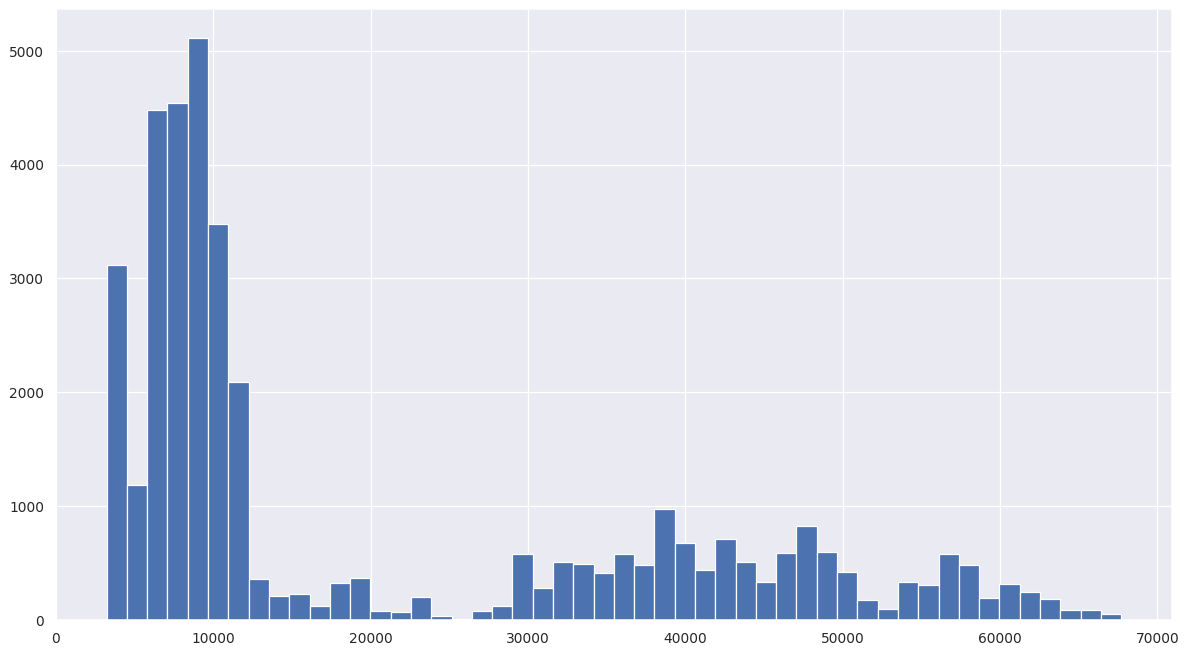

In [17]:
figure_setup()
plt.hist(df["KAMA"], bins=50);

In [18]:
col_name1 = "KAMA"
# col_name2 = "cur_close_vs_" + col_name1
# df[col_name2] = (df[price_type] - df[col_name1])/df[col_name1]
df[col_name1] = data_normalization(df[col_name1], days_range=short_period) 

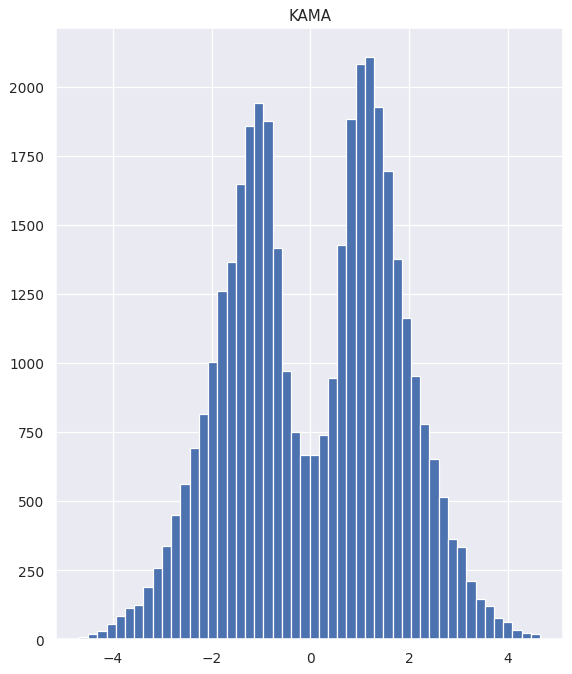

In [19]:
figure_setup()
plt.subplot(121)
plt.hist(df["KAMA"], bins=50)
plt.title("KAMA")
# plt.subplot(122)
# plt.hist(df["cur_close_vs_KAMA"], bins=50)
# plt.title("cur_close_vs_KAMA")
plt.show()

### KST Indicator
*Already normalized by its definition*

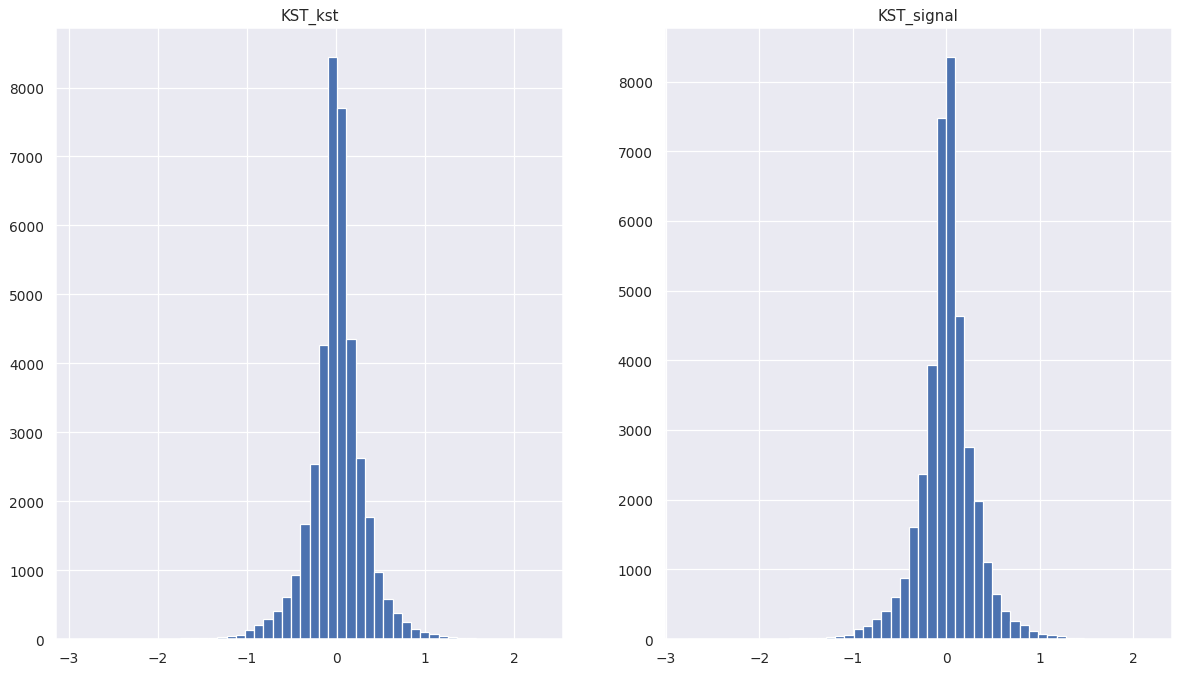

In [20]:
figure_setup()
plt.subplot(121)
df["KST_kst"] /= 100
plt.hist(df["KST_kst"], bins=50)
plt.title("KST_kst")
plt.subplot(122)
df["KST_signal"] /= 100
plt.hist(df["KST_signal"], bins=50)
plt.title("KST_signal")
plt.show()

### MACD Indicator
*Already normalized by its definition*

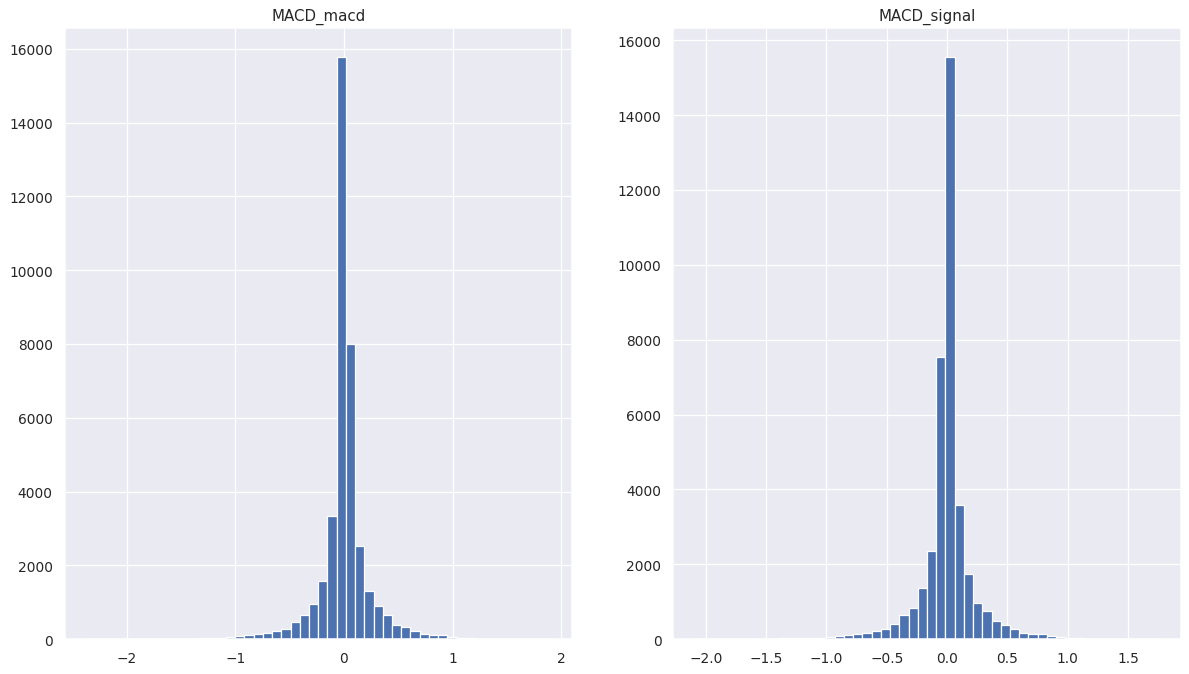

In [21]:
figure_setup()
plt.subplot(121)
df["MACD_macd"]/=1000
plt.hist(df["MACD_macd"], bins=50)
plt.title("MACD_macd")
plt.subplot(122)
df["MACD_signal"] /= 1000
plt.hist(df["MACD_signal"], bins=50)
plt.title("MACD_signal")
plt.show()

### Mass Index

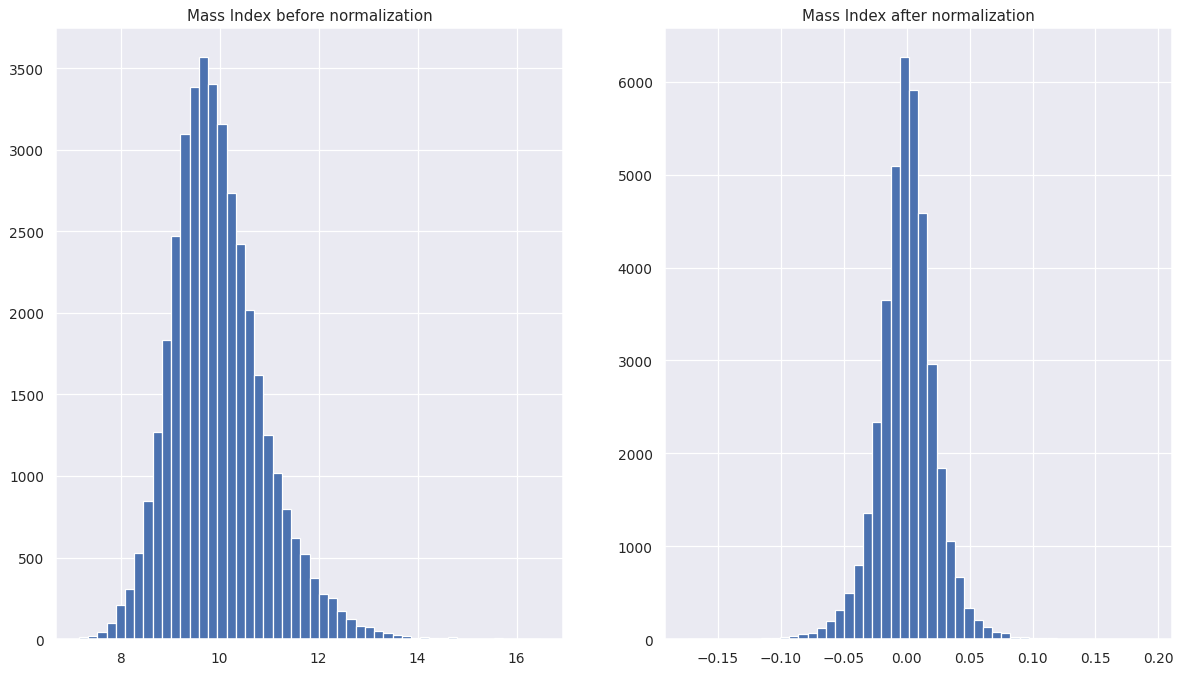

In [22]:
figure_setup()
plt.subplot(121)
plt.hist(df["MassIndex"], bins=50)
plt.title("Mass Index before normalization")
plt.subplot(122)
df["MassIndex"] = np.log(df["MassIndex"]/df["MassIndex"].shift(1))
plt.hist(df["MassIndex"], bins=50)
plt.title("Mass Index after normalization")
plt.show()

### OBV

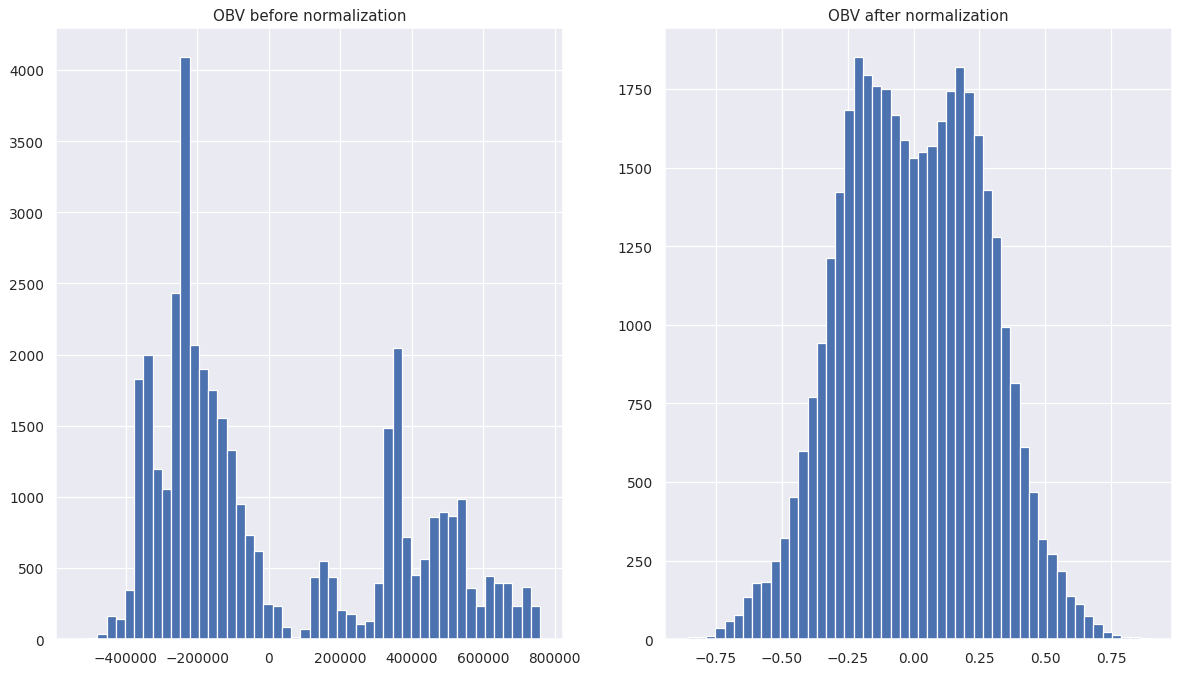

In [23]:
figure_setup()
plt.subplot(121)
plt.hist(df["OBV"], bins=50)
plt.title("OBV before normalization")
plt.subplot(122)
df["OBV"] = data_normalization(df["OBV"])/5
plt.hist(df["OBV"], bins=50)
plt.title("OBV after normalization")
plt.show()

### KVO

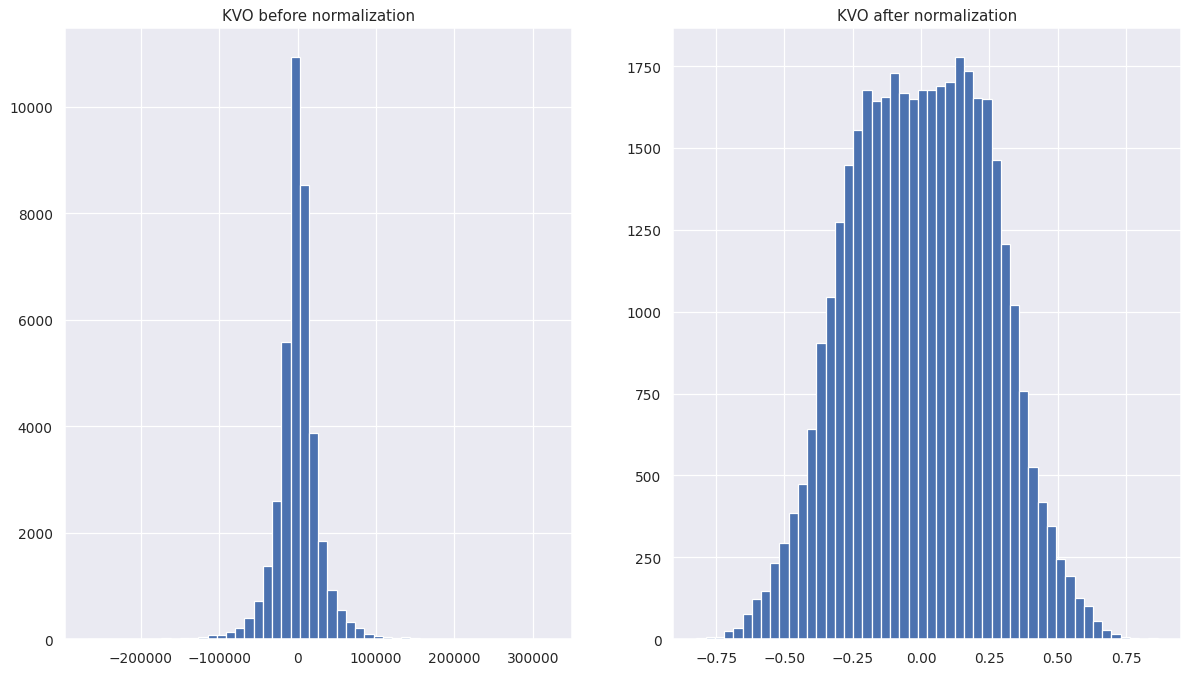

In [24]:
figure_setup()
plt.subplot(121)
plt.hist(df["KVO"], bins=50)
plt.title("KVO before normalization")
plt.subplot(122)
df["KVO"] = data_normalization(df["KVO"])/5
plt.hist(df["KVO"], bins=50)
plt.title("KVO after normalization")
plt.show()

### VWAP

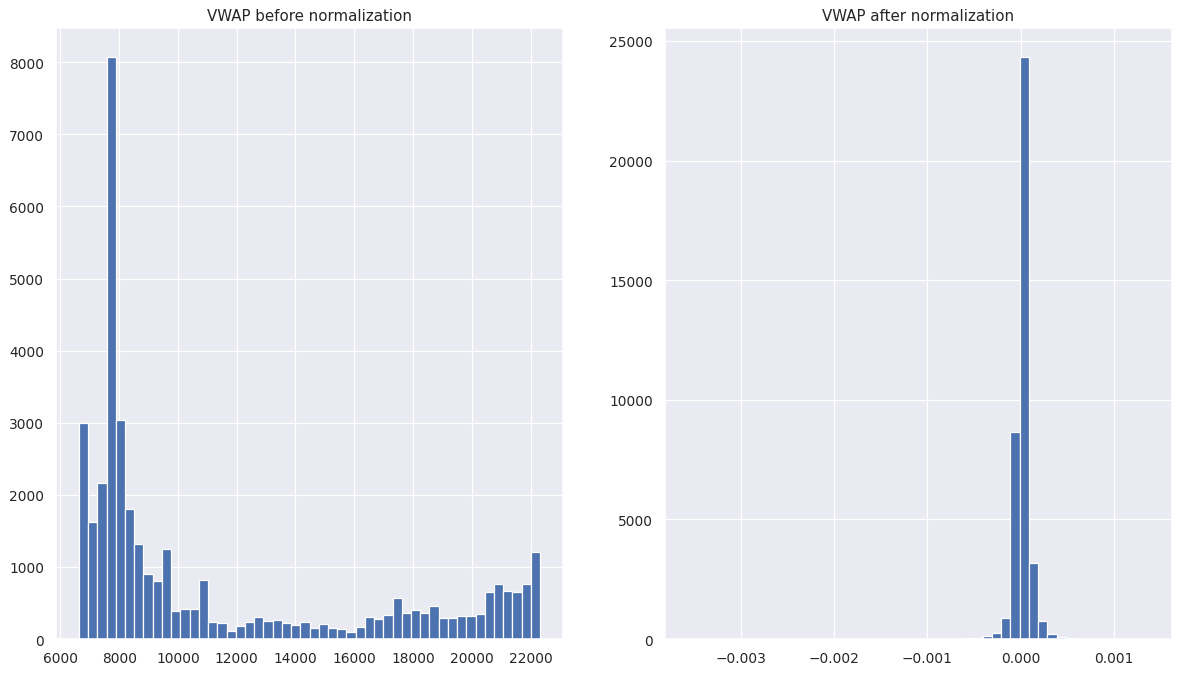

In [25]:
figure_setup()
plt.subplot(121)
plt.hist(df["VWAP"], bins=50)
plt.title("VWAP before normalization")
plt.subplot(122)
df["VWAP"] = np.log(df["VWAP"]/df["VWAP"].shift(1))
plt.hist(df["VWAP"], bins=50)
plt.title("VWAP after normalization")
plt.show()

### AccuDist

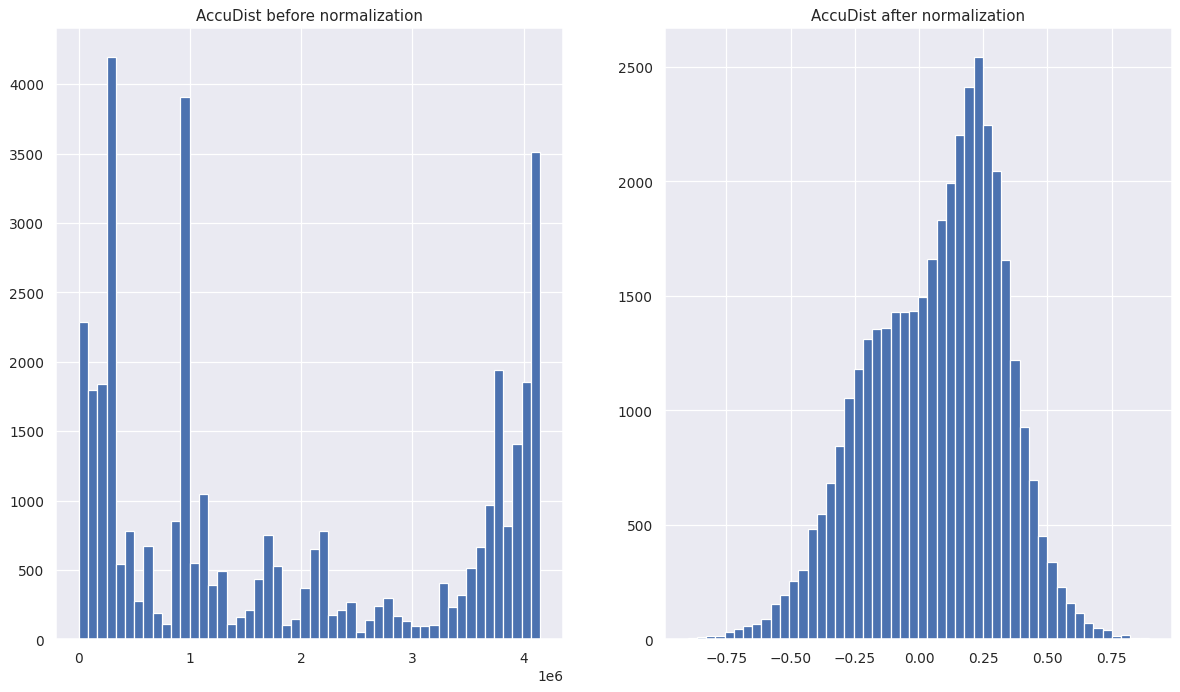

In [26]:
figure_setup()
plt.subplot(121)
plt.hist(df["AccuDist"], bins=50)
plt.title("AccuDist before normalization")
plt.subplot(122)
df["AccuDist"] = data_normalization(df["AccuDist"])/5
plt.hist(df["AccuDist"], bins=50)
plt.title("AccuDist after normalization")
plt.show()

### BOP
*Already normalized by its definition*

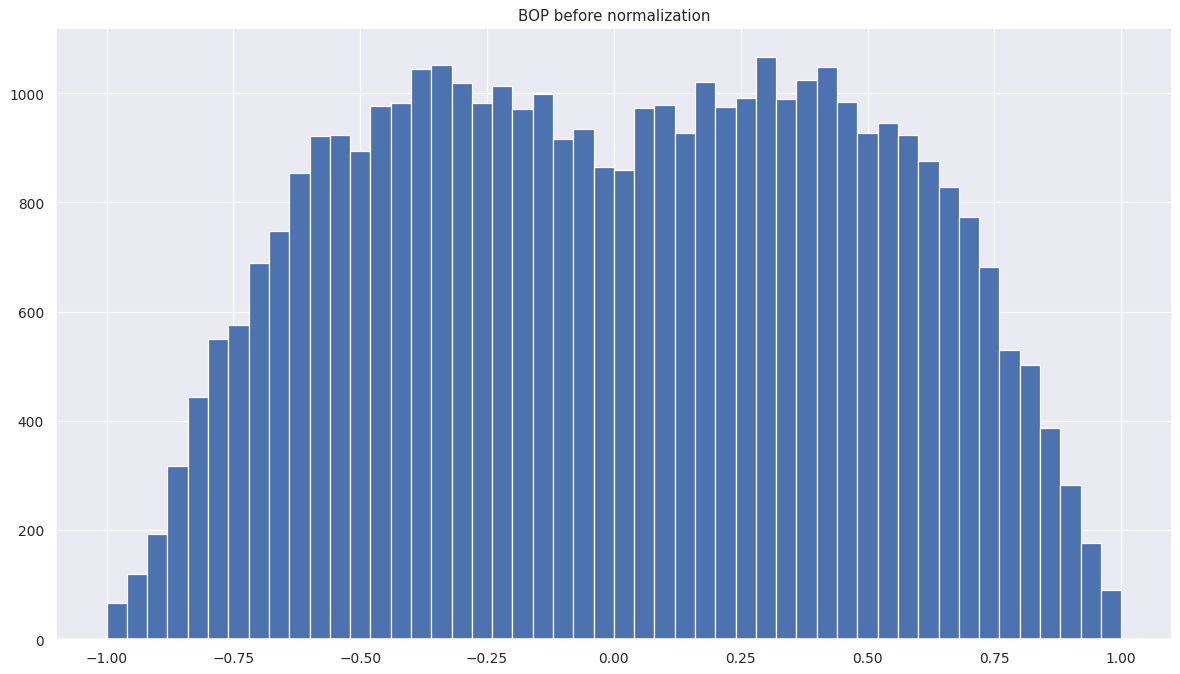

In [27]:
figure_setup()
plt.hist(df["BOP"], bins=50)
plt.title("BOP before normalization")
plt.show()

### UO
*Already normalized by its definition but not in standard normal distribution*

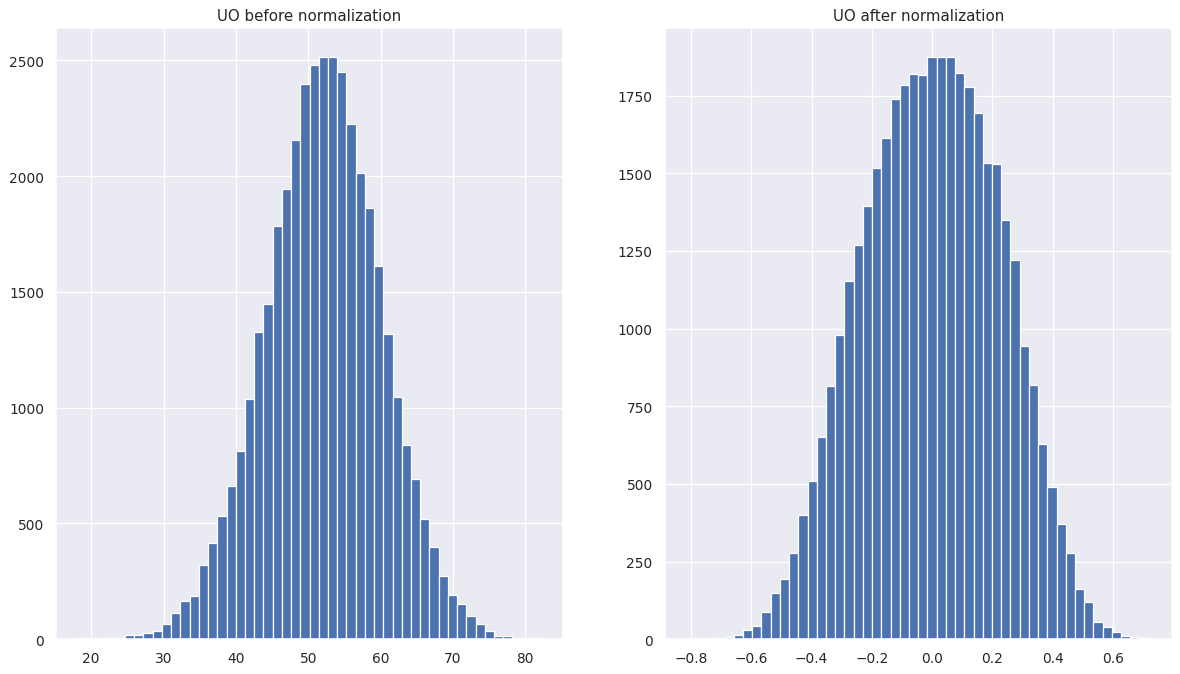

In [28]:
figure_setup()
plt.subplot(121)
plt.hist(df["UO"], bins=50)
plt.title("UO before normalization")
plt.subplot(122)
df["UO"] = data_normalization(df["UO"])/5
plt.hist(df["UO"], bins=50)
plt.title("UO after normalization")
plt.show()

### TSI
*Already normalized by its definition*

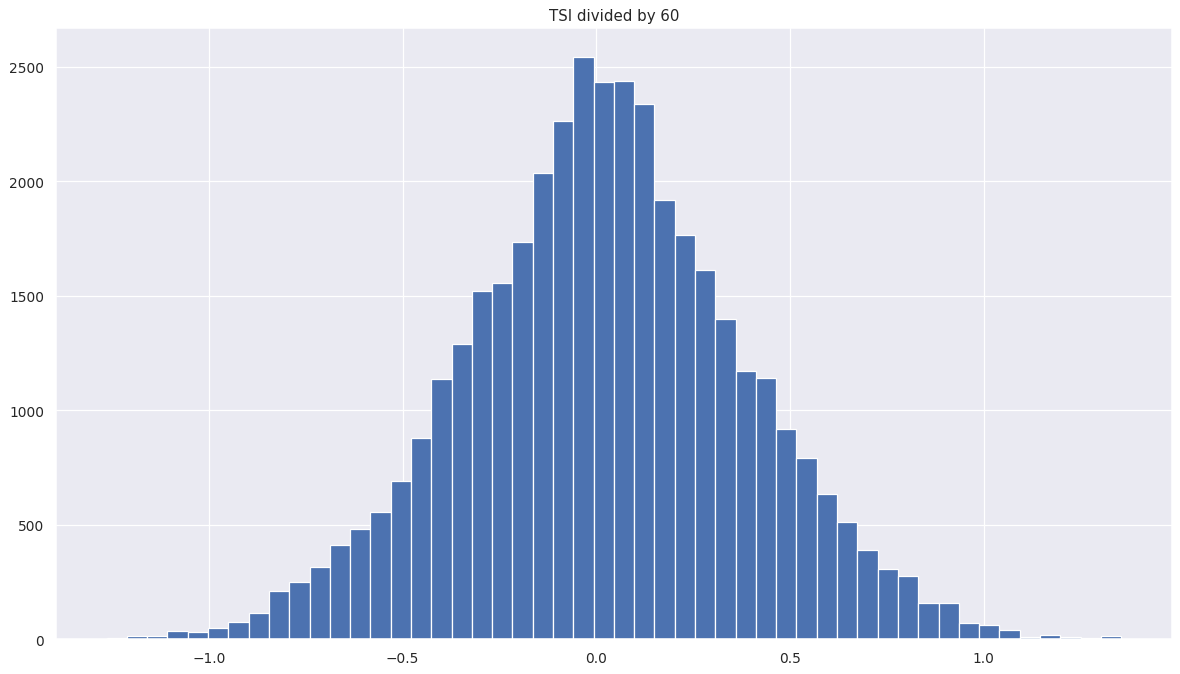

In [29]:
figure_setup()
df["TSI"] /= 60
plt.hist(df["TSI"], bins=50)
plt.title("TSI divided by 60")
plt.show()

### AO
*Already normalized by its definition*

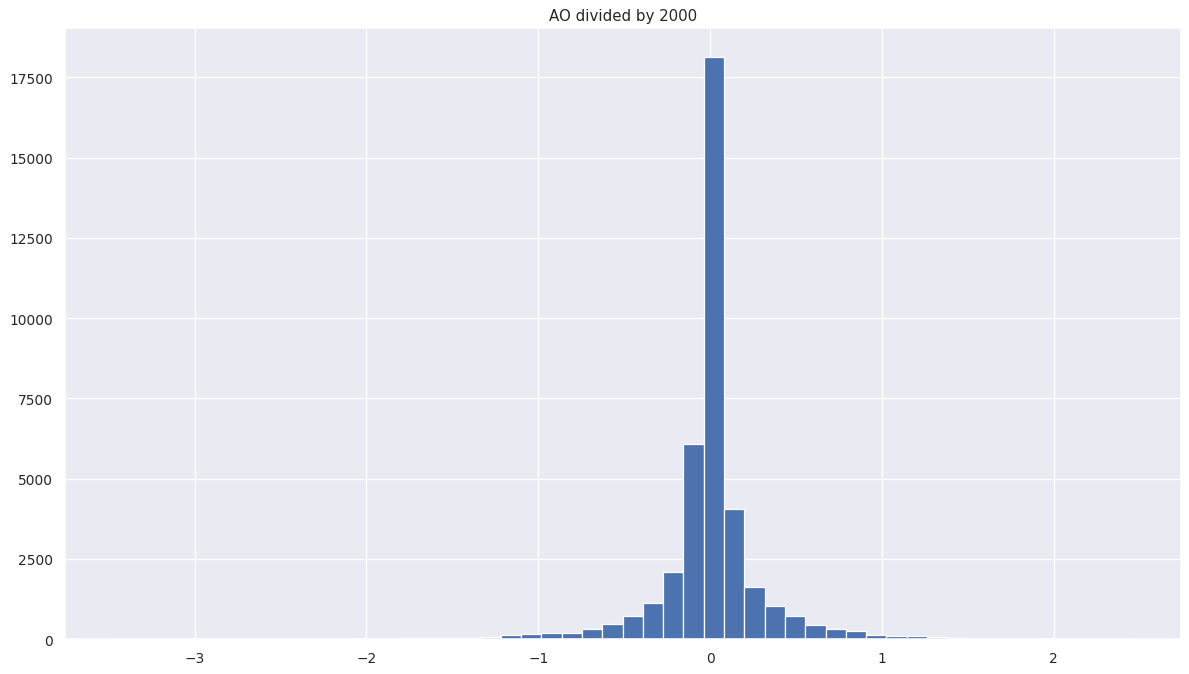

In [30]:
figure_setup()
df["AO"] /= 2000
plt.hist(df["AO"], bins=50)
plt.title("AO divided by 2000")
plt.show()

### CCI

In [31]:
# cci_factor = {
#     4: 125,
#     8: 200,
#     12: 250,
#     16: 250,
#     20: 200,
#     24: 200,
#     36: 200,
#     48: 300,
#     72: 350,
#     96: 350
# }

In [32]:
# i = 0
# fig = figure_setup()
# fig.subplots_adjust(hspace=1)

# while i < 10:
#     fig.add_subplot(5, 2, i+1)
#     df["CCI"+str(periods[i])] /= cci_factor[periods[i]]
#     plt.hist(df["CCI"+str(periods[i])] , bins=50)
#     plt.title("CCI%s divided by %d"%(str(periods[i]), cci_factor[periods[i]]))
#     i += 1

# plt.show()

In [33]:
for period in periods:
    df["CCI"+str(period)]/=100

### CHOP

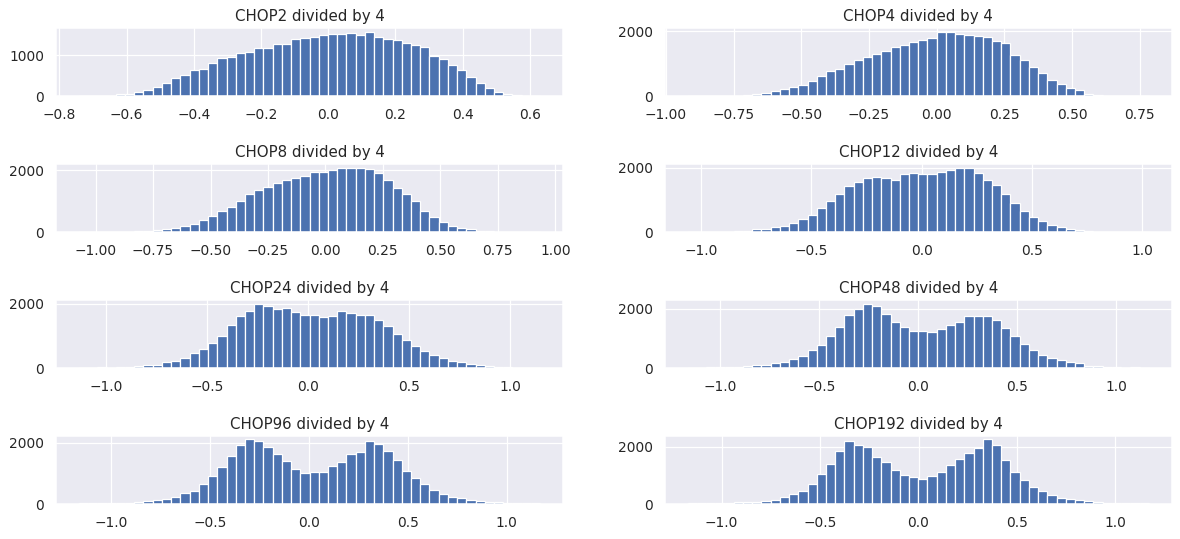

In [34]:
i = 0
fig = figure_setup()
fig.subplots_adjust(hspace=1)

while i < 8:
    fig.add_subplot(5, 2, i+1)
    df["CHOP"+str(periods[i])] = data_normalization(df["CHOP"+str(periods[i])])/4
    plt.hist(df["CHOP"+str(periods[i])] , bins=50)
    plt.title("CHOP%s divided by 4"%(str(periods[i])))
    i += 1

plt.show()

### VTX

In [35]:
for period in periods:
    df["VTX"+str(period)+"_minus_vtx"] -= 1
    df["VTX"+str(period)+"_plus_vtx"] -= 1

### SOBV

In [36]:
for period in periods:
    if period >= 16:
        df["SOBV"+str(period)] = data_normalization(df["SOBV"+str(period)])/5
    df["SOBV"+str(period)] = data_normalization(df["SOBV"+str(period)])/4

### ATR

In [37]:
for period in periods:
    df["ATR"+str(period)] = df["ATR"+str(period)]/original_df["close_SMA"+str(period)]

### Force Index

In [38]:
force_index_factor = {
    2: 1e6,
    4: 7e5,
    8: 5.5e5,
    12: 4.5e5,
    24: 4.5e5,
    48: 4e5,
    96: 3e5,
    192: 2.8e5
}


In [39]:
for period in periods:
#     df["ForceIndex"+str(period)] /= force_index_factor[period]
    df["ForceIndex"+str(period)] /= 1e6

### MeanDev and StdDev

In [40]:
for period in periods:
    for price_type in price_types:
        df[price_type+"_MeanDev%d_over_StdDev%d"%(period,period)] = data_normalization(df[price_type+"_MeanDev"+str(period)]/df[price_type+"_StdDev"+str(period)])
        df[price_type+"_StdDev"+str(period)] = data_normalization(df[price_type+"_StdDev"+str(period)])
        df[price_type+"_MeanDev"+str(period)] = data_normalization(df[price_type+"_MeanDev"+str(period)])

/tmp/ipykernel_134362/3128639797.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[price_type+"_MeanDev%d_over_StdDev%d"%(period,period)] = data_normalization(df[price_type+"_MeanDev"+str(period)]/df[price_type+"_StdDev"+str(period)])
/tmp/ipykernel_134362/3128639797.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[price_type+"_MeanDev%d_over_StdDev%d"%(period,period)] = data_normalization(df[price_type+"_MeanDev"+str(period)]/df[price_type+"_StdDev"+str(period)])
/tmp/ipykernel_134362/3128639797.py:3: PerformanceWarn

/tmp/ipykernel_134362/3128639797.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[price_type+"_MeanDev%d_over_StdDev%d"%(period,period)] = data_normalization(df[price_type+"_MeanDev"+str(period)]/df[price_type+"_StdDev"+str(period)])
/tmp/ipykernel_134362/3128639797.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[price_type+"_MeanDev%d_over_StdDev%d"%(period,period)] = data_normalization(df[price_type+"_MeanDev"+str(period)]/df[price_type+"_StdDev"+str(period)])
/tmp/ipykernel_134362/3128639797.py:3: PerformanceWarn

### RSI

In [41]:
for period in periods:
    for price_type in price_types:
        df[price_type+"_RSI"+str(period)] /= 100

### ROC

In [42]:
roc_divisor = {
    4: 1.6,
    8: 2.3,
    12: 2.8,
    16: 3.2,
    20: 3.7,
    24: 4.1,
    36: 4.8,
    48: 5.6,
    72: 6.9,
    96: 7.9
}


In [43]:
# fig = figure_setup()
# fig.subplots_adjust(hspace=1)

# for price_type in price_types:
#     i = 0
#     while i < 10:
#         df[price_type+"_ROC"+str(periods[i])] /= roc_divisor[periods[i]]
#         if price_type == 'close':
#             fig.add_subplot(5, 2, i+1)
#             plt.hist(df[price_type+"_ROC"+str(periods[i])] , bins=50)
#             plt.title(price_type+"_ROC%s divided by %f"%(str(periods[i]), roc_divisor[periods[i]]))
#         i += 1

# plt.show()

### DPO

In [44]:
dpo_divisor = {
    2: 200,
    4: 210,
    8: 240,
    12: 265,
    24: 285,
    48: 310,
    96: 380,
    192: 440
}

In [45]:
# for price_type in price_types:
#     i = 0
#     while i < 10:
#         df[price_type+"_DPO"+str(periods[i])] = df[price_type+"_DPO"+str(periods[i])].copy()
#         i += 1

In [46]:
# fig = figure_setup()
# fig.subplots_adjust(hspace=1)

# for price_type in price_types:
#     i = 0
#     while i < 10:
#         df[price_type+"_DPO"+str(periods[i])] /= dpo_divisor[periods[i]]
#         print(price_type+"_DPO"+str(periods[i]))
#         print(df[price_type+"_DPO"+str(periods[i])].mean())
#         print(df[price_type+"_DPO"+str(periods[i])].std())
#         print("\n\n")
#         if price_type == 'close':
#             fig.add_subplot(5, 2, i+1)
#             plt.hist(df[price_type+"_DPO"+str(periods[i])] , bins=50)
#             plt.title(price_type+"_DPO%s divided by %f"%(str(periods[i]), dpo_divisor[periods[i]]))
#         i += 1

# plt.show()

In [47]:
for price_type in price_types:
    for period in periods:
        df[price_type+"_DPO"+str(period)] /= 1000

### TRIX

In [48]:
trix_divisor = {
    2: 100,
    4: 50,
    8: 50,
    12: 50,
    24: 40,
    48: 40,
    96: 20,
    192: 20
}


In [49]:
for price_type in price_types:
    for period in periods:
#         df[price_type+"_TRIX"+str(period)] /= trix_divisor[period]
        df[price_type+"_TRIX"+str(period)] /= 50

### CoppockCurve

In [50]:
df["CoppockCurve"] /= 20

### ADX

In [51]:
df["ADX_adx"] = data_normalization(df["ADX_adx"])
df["ADX_plus_di"] = data_normalization(df["ADX_plus_di"])
df["ADX_minus_di"] = data_normalization(df["ADX_minus_di"])

### OHLC

In [52]:
for price_type in price_types:
#     df[price_type] = (df[price_type] - df[price_type].shift(1))/df[price_type].shift(1)
    df[price_type] = np.log(df[price_type]/df[price_type].shift(1))
    for k in ["max", "min", "median"]:
        for period in periods:
            df[price_type+"_"+k+str(period)] = np.log(df[price_type+"_"+k+str(period)])/df[price_type+"_"+k+str(period)].shift(1)

In [53]:
for c in df.columns:
    print(c)

open
high
low
close
volume
quote_asset_volume
number_of_trades
taker_buy_base_asset_volume
taker_buy_quote_asset_volume
exchange_reserve
exchange_reserve_USD
exchange_inflow
exchange_outflow
exchange_in_house_flow
exchange_whale_ratio
exchange_supply_ratio
miner_reserve
miner_reserve_USD
miner_outflow
miner_inflow
coinbase_premium_index
CoppockCurve
KAMA
KST_kst
KST_signal
MACD_macd
MACD_signal
MassIndex
OBV
KVO
VWAP
AccuDist
BOP
UO
TSI
AO
CCI2
CHOP2
VTX2_plus_vtx
VTX2_minus_vtx
SOBV2
ATR2
ForceIndex2
ADX_plus_di
ADX_minus_di
ADX_adx
open_max2
open_min2
open_median2
open_SMA2
open_SMMA2
open_WMA2
open_ALMA2
open_TEMA2
open_EMA2
open_DEMA2
open_DPO2
open_HMA2
open_MeanDev2
open_StdDev2
open_RSI2
open_ROC2
open_TRIX2
close_max2
close_min2
close_median2
close_SMA2
close_SMMA2
close_WMA2
close_ALMA2
close_TEMA2
close_EMA2
close_DEMA2
close_DPO2
close_HMA2
close_MeanDev2
close_StdDev2
close_RSI2
close_ROC2
close_TRIX2
high_max2
high_min2
high_median2
high_SMA2
high_SMMA2
high_WMA2
high_ALMA

In [54]:
cryptoquant_indicators = {
    "exchange_reserve": short_period,
    "exchange_reserve_USD": short_period,
    "exchange_inflow": long_period,
    "exchange_in_house_flow": long_period,
    "exchange_netflow": long_period,
    "exchange_outflow": long_period,
    "coinbase_premium_index": long_period,
    "miner_reserve": medium_period,
    "miner_reserve_USD": short_period,
    "miner_inflow": short_period,
    "miner_outflow": short_period,
    "miner_netflow": short_period
}

In [55]:
kinds_of_data = ["min", "max", "median", "SMA", "MeanDev", "StdDev", "quantile25", "quantile75"]

In [56]:
for cryptoquant_indicator in cryptoquant_indicators.keys():
    df[cryptoquant_indicator] = data_normalization(df[cryptoquant_indicator], days_range=cryptoquant_indicators[cryptoquant_indicator])
    for period in periods:
        for kind_of_data in kinds_of_data:
            if cryptoquant_indicator+"_"+kind_of_data+"_"+str(period) in df.columns:
                df[cryptoquant_indicator+"_"+kind_of_data+"_"+str(period)] = data_normalization(df[cryptoquant_indicator+"_"+kind_of_data+"_"+str(period)], days_range=cryptoquant_indicators[cryptoquant_indicator])

In [61]:
df.iloc[:,i:i+20]

,exchange_netflow_quantile25_12,exchange_netflow_quantile75_12,exchange_netflow_SMA12,exchange_netflow_max12,exchange_netflow_min12,exchange_netflow_median12,exchange_netflow_MeanDev12,exchange_netflow_StdDev12,miner_netflow_quantile25_12,miner_netflow_quantile75_12,miner_netflow_SMA12,miner_netflow_max12,miner_netflow_min12,miner_netflow_median12,miner_netflow_MeanDev12,miner_netflow_StdDev12,exchange_in_house_flow_quantile25_12,exchange_in_house_flow_quantile75_12,exchange_in_house_flow_SMA12,exchange_in_house_flow_max12
0,NaN,NaN,52.316655,696.635772,-348.455720,86.054357,228.957732,279.922924,NaN,NaN,-69.290370,185.213077,-427.348934,-12.947680,200.783880,221.660426,NaN,NaN,854.244951,1507.039988
1,NaN,NaN,47.994670,696.635772,-348.455720,60.122448,224.635747,279.089451,NaN,NaN,-83.400219,185.213077,-427.348934,-14.971551,189.025672,210.688806,NaN,NaN,826.798479,1507.039988
2,NaN,NaN,14.247246,696.635772,-348.455720,-43.351436,223.884159,277.207840,NaN,NaN,-75.799498,276.421731,-427.348934,-14.971551,195.359606,221.604519,NaN,NaN,837.135735,1507.039988
3,NaN,NaN,40.988158,696.635772,-348.455720,60.122448,218.978418,275.653868,NaN,NaN,-69.711341,276.421731,-427.348934,9.113822,200.433070,223.580673,NaN,NaN,825.564491,1507.039988
4,NaN,NaN,-10.934666,696.635772,-842.935838,60.122448,279.555046,364.319887,NaN,NaN,-104.637856,276.421731,-427.348934,-76.724427,209.932109,229.672976,NaN,NaN,851.791312,1507.039988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38802,-1.786516,-0.426694,-242.846421,441.688991,-953.832885,-266.776227,434.957979,493.819761,0.872844,-0.346933,32.820610,61.453789,2.401691,38.259657,14.729893,17.481788,-0.462738,-0.571670,773.809433,1853.223560
38803,-1.657190,-0.425731,-197.814924,441.688991,-953.832885,-127.373672,423.759411,486.864661,0.751998,-0.426357,29.872359,61.453789,2.401691,35.319145,16.891013,18.867821,-0.463826,-0.573606,635.319897,1853.223560
38804,-1.646919,-0.424768,-173.516188,441.688991,-953.832885,4.073836,438.832102,491.957920,0.761408,-0.520945,29.278866,61.453789,2.401691,35.319145,16.396436,18.220910,-0.462752,-0.573207,681.023766,1853.223560
38805,-0.678587,-0.423806,-104.012003,441.688991,-928.251833,4.073836,357.743887,432.077762,0.770956,0.205257,30.202390,61.453789,2.401691,35.319145,17.166039,18.981413,-0.462761,-0.573189,567.568557,1608.029103


In [58]:
# original_df = pd.read_csv("test.csv")
# df["label"] = (original_df["close"] - original_df["close"].shift(1) >= 0).shift(-1)
# df.dropna(inplace=True)

In [66]:
# df.to_csv("normalized_data.csv")